# <center>Logistic Regression</center>
<center>DATA 558, Spring 2021</center>
<center>Author: Apoorv Sharma</center>

#### 2a

$$
F(\beta) = log(1 + exp(-yx\beta)) + \lambda \beta^2
$$

$$
\frac{d}{d \beta} F(\beta) = (1 + exp(-yx\beta))^{-1} \cdot exp(-yx\beta) \cdot (-yx) + 2 \lambda \beta
$$

$$
= -yx \frac{exp(-yx\beta)}{1 + exp(-yx\beta)} + 2\lambda \beta
$$

#### 2b

$$
F(\beta) = \frac{1}{n} \sum _{i=1}^n log(1+exp(-y_i x_i^T \beta)) + \lambda\mid\mid\beta\mid\mid _2^2
$$

$$
F(\beta) = f(\beta) + g(\beta)
$$

$$
\therefore \frac{d}{d \beta} F(\beta) = \frac{d}{d \beta} f(\beta) + \frac{d}{d \beta} g(\beta)
$$

where 

$$f(\beta) = \frac{1}{n} \sum _{i=1}^n log(1+exp(-y_i x_i^T \beta))$$ 

and 

$$g(\beta) = \lambda\mid\mid\beta\mid\mid _2^2$$

Thus, 

$$
\frac{d}{d \beta} f(\beta) = \sum _{i=1}^n -y_ix_i \frac{exp(-y_ix^T_i\beta)}{1 + exp(-y_ix^T_i\beta)}
$$

and 

$$
\frac{d}{d \beta} g(\beta) = 2 \lambda \beta
$$

Hence
$$
\therefore \frac{d}{d \beta} F(\beta) = \sum _{i=1}^n -y_ix_i \frac{exp(-y_ix^T_i\beta)}{1 + exp(-y_ix^T_i\beta)} + 2 \lambda \beta
$$

#### 2c

This dataset contains trading information for the S&P 500 over 1250 days from 2001 to 2005. For each date we have the percent return from the previous 5 days (the Lag features), the volume of shares traded (in billions), the percent return on the date itself (Today), and whether the market moved up or down (Direction). We will apply our gradient descent and fast gradient descent algorithms to fit a logistic regression model for the binary outcome Direction based on the features Lag1, Lag2, and Volume.

In [448]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pyplot as plt
from tqdm import tqdm

In [449]:
file = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv' 
smarket = pd.read_csv(file, sep=',', header=0, index_col=0)

In [450]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [451]:
smarket.isnull().sum(axis=0)

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

#### 2d

Construct the matrix of features and the response. Transform the response to a vector with entries in {+1,−1}, corresponding to whether Direction is ‘Up’ or ‘Down’, respectively. Split the data into train and test sets (80/20 split) and standardize the features.


In [452]:
cleanup_nums = {"Direction": {"Up": 1, "Down": -1}}
smarket.replace(cleanup_nums, inplace=True)

In [453]:
X = smarket[['Lag1', 'Lag2', 'Volume']]
y = smarket[['Direction']]

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [455]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
# y_train_scaled = scaler.transform(y_train.values.reshape(-1, 1)).reshape((-1))
# y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).reshape((-1))

In [456]:
y_train_scaled = y_train.to_numpy().reshape(-1, 1).reshape((-1))
y_test_scaled = y_test.to_numpy().reshape(-1, 1).reshape((-1))

In [457]:
print(f"X_train dimensions: {X_train_scaled.shape}\nX_test dimensions:{X_test_scaled.shape}\ny_train dimensions:{y_train_scaled.shape}\ny_test dimensions:{y_test_scaled.shape}")

X_train dimensions: (1000, 3)
X_test dimensions:(250, 3)
y_train dimensions:(1000,)
y_test dimensions:(250,)


#### 2e

Write a function computegrad that computes and returns ∇F(β) for any β.

In [458]:
def computegrad(beta, lambda_, X=X_train_scaled, Y=y_train_scaled):
    N = X.shape[0] #number of rows
    
    p = (np.exp( np.multiply(-Y, X.dot(beta)) )) / (1 + np.exp( np.multiply(-Y, X.dot(beta)) ))
    Q = np.diag(p)
    
    return (-1/N) * X.T.dot(Q).dot(Y) + (2 * lambda_ * beta)

In [459]:
initial_beta = np.zeros(X_train_scaled.shape[1])
computegrad(np.zeros(X_train_scaled.shape[1]), 0.5, X_train_scaled, y_train_scaled)

array([ 0.01839009,  0.01364029, -0.01466941])

#### 2f

Write a function backtracking that implements the backtracking rule.

In [460]:
# np.multiply(-y_train_scaled, X_train_scaled.dot(initial_beta))

In [461]:
def log_reg_obj_func(beta, lambda_, X=X_train_scaled, Y=y_train_scaled):
    N = X.shape[0]
    return 1/N * np.sum( np.log( 1 + np.exp(np.multiply(-Y, X.dot(beta))) ) ) + lambda_ * np.linalg.norm(beta)**2

In [462]:
def backtracking(eta_init, decay_rate, prop_constant, f, f_grad, x, p, lambda_):
    """Backtracking algorithm for stepsize selection.

	Parameters
	----------
	eta_init : float
		A positive number representing the starting, maximum stepsize.
    decay_rate : float
		A number in (0, 1) indicating how much to decrease eta while backtracking.
    prop_constant : float
		A number the proportionality between the amount of descent and directional derivative.
    f : function
		An objective function that maps a numpy array to a float.
    f_grad : function
		A function that computes the gradient of f at a point x. 
        Maps a 1D numpy array to a numpy array of the same size.
    x : numpy.ndarray
		A 1D array representing a point in d-dimensional space.
    p : numpy.ndarray
		A 1D array (unit vector) representing a direction in d-dimensional space.

	Returns
	-------
	eta : float
		The first eta value that satisfies the sufficient decrease condition.
	"""
        
    def sufficient_decrease(eta):
        return f(x + eta * p, lambda_) - f(x, lambda_) <= prop_constant * eta * np.dot(f_grad(x, lambda_), p)
    
    eta = eta_init
    while not sufficient_decrease(eta):
        eta *= decay_rate
    
    return eta

In [463]:
p = -computegrad(np.zeros(X_train_scaled.shape[1]), 0.5, X_train_scaled, y_train_scaled)
backtracking(0.1, 0.8, 0.5, log_reg_obj_func, computegrad, initial_beta, p, 0.5)

0.1

In [464]:
p = -computegrad(np.zeros(X_train_scaled.shape[1]), 0.5, X_train_scaled, y_train_scaled)
# p = np.linalg.norm(p)
p

array([-0.01839009, -0.01364029,  0.01466941])

#### 2g

Write a function graddescent that implements the gradient descent algorithm with the backtracking rule to tune the step-size. The function graddescent calls computegrad and backtracking as subroutines. The function takes as input the initial point, the initial step-size value, and the target accuracy ε. The stopping criterion is ∥∇F ∥ ≤ ε.

In [465]:
def graddescent(initial_loc, max_iters, lambda_, stopping_thresh, lr = 0.1, X=X_train_scaled, y=y_train_scaled):
    
    # Don't want to change the starting location
    beta = initial_loc
    
    lr = lr
    beta_grad = computegrad(beta, lambda_, X, y)
    beta_list = [beta]
    
    decay_rate = 0.8
    prop_constant = 0.5
    
    # Keep descending for 'max_iters'
    i = 0
    while np.linalg.norm(beta_grad) > stopping_thresh:
        lr = backtracking(lr, decay_rate, prop_constant, log_reg_obj_func, computegrad, beta, -beta_grad, lambda_)
        
        beta = beta - lr * beta_grad
        beta_list.append(beta)
        
        beta_grad = computegrad(beta, lambda_, X, y)
        i += 1
        
    return np.array(beta_list)

#### 2h

Write a function fastgradalgo that implements the fast gradient algorithm described in Algorithm 1. The function fastgradalgo calls computegrad and backtracking as subrou- tines. The function takes as input the initial step-size value for the backtracking rule and the target accuracy ε. The stopping criterion is ∥∇F ∥ ≤ ε.

In [466]:
def fastgradalgo(initial_loc, max_iters, lambda_, stopping_thresh, lr = 0.1, X=X_train_scaled, y=y_train_scaled):
    
    # Don't want to change the starting location
    beta = initial_loc
    theta = initial_loc
    
    lr = lr
    beta_grad = computegrad(beta, lambda_, X, y)
    beta_list = [beta]
    
    decay_rate = 0.8
    prop_constant = 0.5
    
    # Keep descending for 'max_iters'
    i = 0
    while np.linalg.norm(beta_grad) > stopping_thresh:
        lr = backtracking(lr, decay_rate, prop_constant, log_reg_obj_func, computegrad, beta, -beta_grad, lambda_)
        
        beta_prev = beta
        
        beta = theta - lr * beta_grad
        theta = beta + i / (i + 3) * (beta - beta_prev)
        
        beta_list.append(beta)
        beta_grad = computegrad(beta, lambda_, X, y)
        i += 1
        
    return np.array(beta_list)

#### 2i

Initialize the step size to η0 = 0.1. Set the target accuracy to ε = 1 × 10 . Run
graddescent and fastgradalgo on the training set of the smarket dataset for λ = 0.5. Plot the curve of the objective values F(βt) for both algorithms versus the iteration counter t (use different colors). What do you observe?

Text(0, 0.5, 'Logistic Regression Objective values')

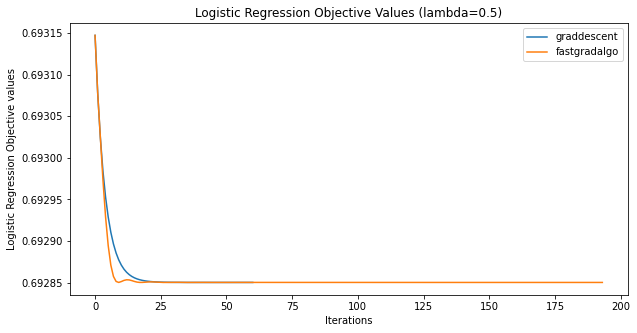

In [467]:
(N, p) = X_train_scaled.shape
lambda_ = 0.5
epsilon = 1e-5
max_iters = 1000
lr = 0.1
    
initial_beta = np.zeros(p)

beta_list_grad = graddescent(initial_beta, max_iters, lambda_, epsilon, lr, X_train_scaled, y_train_scaled)
beta_list_fastGrad = fastgradalgo(initial_beta, max_iters, lambda_, epsilon, lr, X_train_scaled, y_train_scaled)

objective_vals_grad = [log_reg_obj_func(b, lambda_) for b in beta_list_grad]
objective_vals_fastGrad = [log_reg_obj_func(b, lambda_) for b in beta_list_fastGrad]

plt.figure(figsize=(10,5))

plt.plot(objective_vals_grad, label='graddescent')
plt.plot(objective_vals_fastGrad, label='fastgradalgo')

plt.legend()

plt.title(f'Logistic Regression Objective Values (lambda={lambda_})')
plt.xlabel('Iterations')
plt.ylabel('Logistic Regression Objective values')

It can be seen that the fast gradient minimizes the objective value faster compared to the regular gradient descent algorithm. 

However, the fast gradient descent algorithm takes more iterations to reach the stopping condition. 

#### 2j

Denote by βT the final iterate of your fast gradient algorithm. Compare βT to the β⋆ found by scikit-learn’s LogisticRegression(). Compare the objective value for βT
⋆
to the one for β . What do you observe? Note: Remember that scikit-learn penalizes the logistic regression objective differently from our formulation above. You will need to find the setting of their C parameter that corresponds to a given choice of λ in our definition.

In [468]:
beta_t = beta_list_fastGrad[-1]
objective_val_t = log_reg_obj_func(beta_t, lambda_)

In [469]:
model_parms = {'tol': epsilon, 'C': 1/(2*N*lambda_), 'fit_intercept': False}
clf = LogisticRegression(random_state=0).set_params(**model_parms).fit(X_train_scaled, y_train_scaled)

In [470]:
beta_star = clf.coef_[0]
objective_val_star = log_reg_obj_func(beta_star, lambda_)

In [471]:
print(f"beta_T:\n{beta_t}\n\n beta_star:\n{beta_star}")
print(f"\nbeta_T obj : {objective_val_t:.8f}\nbeta_star obj: {objective_val_star:.8f}")

beta_T:
[-0.01487086 -0.01090969  0.01171263]

 beta_star:
[-0.01486617 -0.01091292  0.01171745]

beta_T obj : 0.69285012
beta_star obj: 0.69285012


#### 2k

Run cross-validation on the training set of the smarket dataset using scikit-learn to find
the optimal value of λ (see sklearn.linear model.LogisticRegressionCV). Again,
note that scikit-learn’s penalty C is not the same as our λ. Find the value λ∗ cor-
responding to the best choice C∗ obtained with this method. Run graddescent and ∗
fastgradalgo to optimize the objective with λ = λ . Plot the curve of the objective val- ues F(βt) for both algorithms versus the iteration counter t. Plot the misclassification error on the training set for both algorithms versus the iteration counter t. Plot the misclassification error on the test set for both algorithms versus the iteration counter t. What do you observe?

In [472]:
model_parms = {'tol': epsilon, 'fit_intercept': False}
clf = LogisticRegressionCV(random_state=0).set_params(**model_parms).fit(X_train_scaled, y_train_scaled)

In [473]:
C_star = clf.C_[0]
lambda_star = 1/(2*N*C_star)
lambda_star

5.0

In [474]:
C_star

0.0001

In [475]:
beta_star = clf.coef_[0]
objective_val_star = log_reg_obj_func(beta_star, lambda_)

Text(0, 0.5, 'Logistic Regression Objective values')

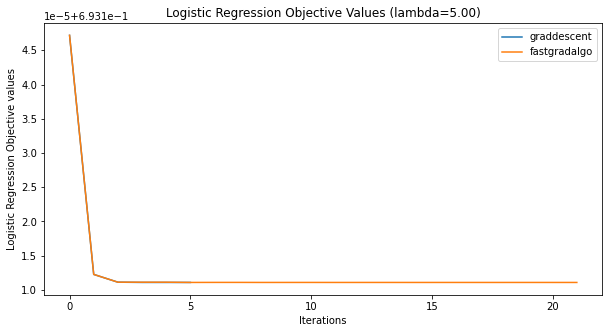

In [476]:
(N, p) = X_train_scaled.shape
lambda_ = lambda_star
epsilon = 1e-5
max_iters = 1000
lr = 0.1
    
initial_beta = np.zeros(p)

beta_list_grad = graddescent(initial_beta, max_iters, lambda_, epsilon, lr, X_train_scaled, y_train_scaled)
beta_list_fastGrad = fastgradalgo(initial_beta, max_iters, lambda_, epsilon, lr, X_train_scaled, y_train_scaled)

objective_vals_grad = [log_reg_obj_func(b, lambda_) for b in beta_list_grad]
objective_vals_fastGrad = [log_reg_obj_func(b, lambda_) for b in beta_list_fastGrad]

plt.figure(figsize=(10,5))

plt.plot(objective_vals_grad, label='graddescent')
plt.plot(objective_vals_fastGrad, label='fastgradalgo')

plt.legend()

plt.title(f'Logistic Regression Objective Values (lambda={lambda_:.2f})')
plt.xlabel('Iterations')
plt.ylabel('Logistic Regression Objective values')

Observation: With an optimal lambda value, the fast gradient algorithm is reaching the minimum faster compared to regular gradient descent. However, it still takes more iterations to reach the stopping condition. 

In [477]:
beta_t = beta_list_fastGrad[-1]
objective_val_t = log_reg_obj_func(beta_t, lambda_)

In [478]:
print(f"beta_T:\n{beta_t}\n\n beta_star:\n{beta_star}")
print(f"\nbeta_T obj : {objective_val_t:.8f}\nbeta_star obj: {objective_val_star:.8f}")

beta_T:
[-0.00179674 -0.00133104  0.0014312 ]

 beta_star:
[-0.00179644 -0.00133075  0.00143088]

beta_T obj : 0.69311109
beta_star obj: 0.69307939


In [479]:
def predict(beta, X):
    # p = 1 / (1 + np.exp(-X.dot(beta)))
    p = np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))
    y_pred = np.where(p > 0.5, 1, -1)
    return y_pred

In [480]:
def get_error(y_true, y_pred):
    return np.mean(y_pred != y_true)

In [481]:
err_grad_test = [get_error(y_test_scaled, predict(beta, X_test_scaled)) for beta in beta_list_grad]
err_fastGrad_test = [get_error(y_test_scaled, predict(beta, X_test_scaled)) for beta in beta_list_fastGrad]

err_grad_train = [get_error(y_train_scaled, predict(beta, X_train_scaled)) for beta in beta_list_grad]
err_fastGrad_train = [get_error(y_train_scaled, predict(beta, X_train_scaled)) for beta in beta_list_fastGrad]

In [482]:
def plot_misclassification_error(err_grad, err_fastGrad, title_postfix='Test'):
    plt.figure(figsize=(10,5))

    plt.plot(err_grad, label='graddescent')
    plt.plot(err_fastGrad, label='fastgradalgo')

    plt.legend()

    plt.title(f'Misclassification Error {title_postfix}')
    plt.xlabel('Iterations')
    plt.ylabel('Error Rate')

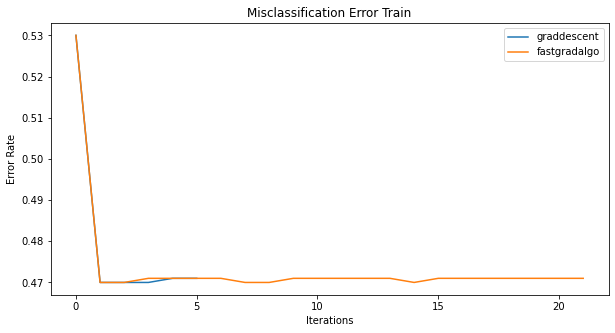

In [483]:
plot_misclassification_error(err_grad_train, err_fastGrad_train, title_postfix="Train")

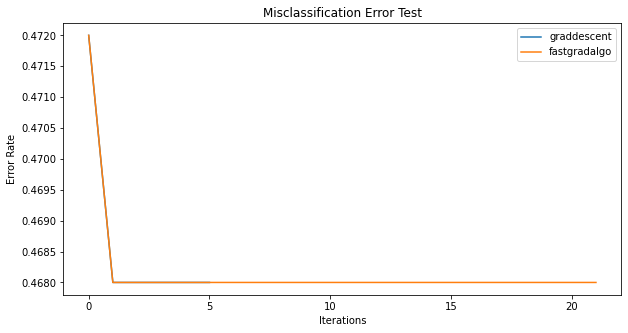

In [484]:
plot_misclassification_error(err_grad_test, err_fastGrad_test, title_postfix="Test")

Observation: 

The fast gradient algorithm reaches the minimal error rate faster compared to the regular gradient descent algorithm This can be seen for both the test and training sets.